# Chapter 7: Webscraping

---
## Webscraping and parsing

The web is a giant repository of (textual) information and the need to extract information from it automatically is clear. One very useful application of scripts is for processing online data. 

Web scraping is a computer software technique of **extracting information from websites**. This involves 1) fetching the HTML document of a webpage and 2) parsing: the transformation of unstructured data (HTML format) on the web into structured data (database or spreadsheet).

Python has many excellent pre-made software suites (or *libraries*) and is thus ideal for this purpose. Today we will give a few examples using the `requests` library for fetching pages, and the `bs4` (BeautifulSoup) library for parsing HTML.

Let's take these libraries for a spin! Suppose we want to know what LT3 researchers like to write about, by collecting a corpus of paper abstracts from the [LT3 publications page](https://www.lt3.ugent.be/publications/). First, we want to crawl links to individual paper pages, where the abstracts can be found.

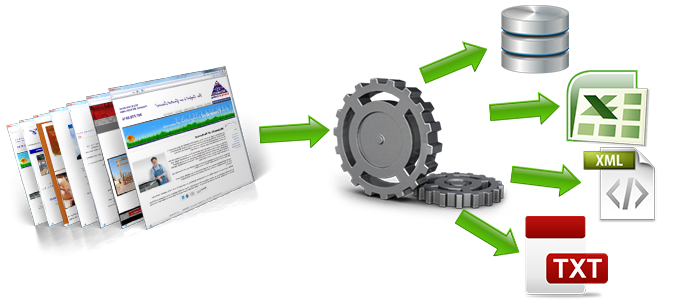

## Fetching a webpage

In [ ]:
import requests
import bs4

r = requests.get('https://www.lt3.ugent.be/publications') # This will store a "Response" object in r
html = r.text # Response objects have an attribute "text" which contains the HTML of the page
print(html)

In the above code block we first import the requests and beautifulsoup4 libraries, which came pre-installed in the Conda distribution.

We then fetch the webpage from the URL using the get() function. This returns a "Response" object which contains the HTML text and meta-data of the page. When we extract the HTML only, we can start to parse it. But first we have a short look at the HTML language.

## Introduction to HTML
HTML stands for HyperText Markup Language, and is the language used to describe (markup) web pages. It is the underlying language to structure web-page content. HTML itself does not determine the way things look – it only helps to classify and structure content. It is your browser's job to receive and process the HTML so they can be displayed.


### HTML Elements
A HTML document is a structured representation of content which is subdivided in elements. Elements are the building blocks of a page. HTML tags label pieces of content such as "heading", "paragraph", "table", and so on. Browsers do not display the HTML tags, but use them to render the content of the page.

Elements are identified by ‘tags’, their name.
HTML tags usually come in pairs: the opening tag <tagname> and a closing tag with a forward slash for the tagname `</tagname>`.
Tags can have an inner text and “attributes” (named properties):
```
<tag attribute=”value”>text</tag>

Common tags:
    <html> – the whole document
    <body> – the human-readable part of the web page
    <table> – the frame of a table element
    <a> – a hyperlink or url
    <tr> – a row in a table
    <td> – a cell of content inside a row
    <th> – a table header cell inside a row
```

A web page contains of a series of these elements which can be recursively embedded into eachother. Here is an example of a very simple page:

```
 <!DOCTYPE html>
<html>
    <head>
        <title>Page Title</title>
    </head>
    <body>

        <h1>My First Heading</h1>
        <p>My first paragraph.</p>

    </body>
</html> 
```

You can view the HTML source of any webpage in your browser by right clicking and selecting "View source" from the menu.

### HTML links
HTML links are elements 
defined with the `<a>` tag. The URL itself the value assigned to the href attribute.
```
<a href="https://www.w3schools.com">This is a link</a>
```

### More resources
Here are some tutorials on HTML, if you want to learn more out of interest or because you will be scraping for your final project.

W3School introduction to HTML: https://www.w3schools.com/html/


## Parsing the page
You do not need to fully understand HTML to start webscraping as a lot of the heavy lifting can be done by the BeautifulSoup4 library. BeautifulSoup will process the raw HTML text document so we can easily obtain elements and content from it.

In [ ]:
import requests
import bs4

r = requests.get('https://www.lt3.ugent.be/publications') # This will store a "Response" object in r
html = r.text # Response objects have an attribute "text" which contains the HTML of the page
soup = bs4.BeautifulSoup(html, "lxml") # This returns a parsed HTML object
links = []
for link in soup.find_all("a"): # Try help(soup.find_all) to understand what this does.
                                # It takes a lot of work out of your hands!
    print(link["href"])
    links.append(link["href"]) # Let's store all the links found on this page for later

We obtain the URL links by finding all `<a>` tags and getting their href value.

We now have a list of all the links that we found on `https://www.lt3.ugent.be`. Not all of them are links to individual paper pages, and they are also relative links. Let's fix that!

For the first problem, we can use the fact that all individual pages have a link of the form `/publications/slug-of-publication-name/`. In other words, they all start with `/publications/` and end with a trailing slash. Note that the link `/publications/` also satisfies these conditions, so we need to make sure that there are exactly 3 slashes. Of course, you could come up with other rules for getting the right links, this is just one solution.

This is a perfect time for using list comprehensions! We have a list of links, and we want to improve it.

In [ ]:
links = [l for l in links if l.startswith("/publications/")]
links = [l for l in links if l.endswith("/")]
links = [l for l in links if l.count("/") == 3]
print(links)

In [ ]:
# Now, let's prefix all the links with the domain name, so we get absolute links instead of relative ones
links = ["https://www.lt3.ugent.be" + l for l in links] # Simple string concatenation!
print(links)

Now that we have a list of absolute links it is time to get our abstracts! By looping over all these links, downloading each page and extracting what we want from it, we can fill a list with abstracts.

#### DIY 1
Open https://www.lt3.ugent.be/publications/how-do-students-cope-with-machine-translation-outp/ > `right-click` > `View Source`. Which element contains the abstract? What are its attribute and values?

#### DIY 2
Your browser has an even faster way of inspecting HTML elements we are interested in extracting: `Right click directly unto the content` > `Inspect (element)`. This will bring directly to the tag containing the content in the source.

Open https://www.lt3.ugent.be/publications/how-do-students-cope-with-machine-translation-outp/, inspect the publication's title. Which element contains the title?

In [ ]:
# let's get the abstracts from the elements
abstracts = []
for link in links:
    print(link)
    r = requests.get(link) # get the request object for the link
    soup = bs4.BeautifulSoup(r.text, "lxml")
    abstract_div = soup.find("div", {"class": "full-text",}) # find div elements with "textfield" as class attribute
    print(abstract_div)
    if abstract_div: # Sometimes this is None, when a publication page has no abstract
        # We are only interested in the text of the abstract, not the HTML code around it (div and p tags)
        # BeautifulSoup objects make it very easy to access child elements of an HTML object, using dot notation
        abstract = abstract_div.p.text # because every abstract_div contains a p containing text
        abstracts.append(abstract)
print("Finished crawling", len(abstracts), "abstracts!")

Hooray, we collected a bunch of abstracts! Let's have some fun with them!

In [ ]:
## Make a frequency dictionary
freq_dict = {}
for abstract in abstracts:
    words = abstract.lower().split()
    for word in words:
        freq_dict[word] = freq_dict.get(word, 0) + 1

## Find the most frequent words
freq_tuples = list((freq, word) for word, freq in freq_dict.items()) # We need to have the frequency first
freq_tuples.sort() # Because that is what we want to sort on
freq_tuples.reverse() # In descending order
print("The top 30 most frequently used words are:")
for freq, word in freq_tuples[:30]:
    print(freq, word)

# Get the tuples for which the word is longer than 5 characters (to get fewer function words)
freq_tuples = [tup for tup in freq_tuples if len(tup[1]) > 5]
print("The top 30 most frequently used words longer than 5 characters are:")
for freq, word in freq_tuples[:30]:
    print(freq, word)
    
abstract_word_lengths = [len(a.split()) for a in abstracts]
print("Average abstract length in words:", sum(abstract_word_lengths)/len(abstract_word_lengths))


---
## Working with libraries

In the previous scraping example we have worked with the requests and BeautifulSoup4 software libraries. Libraries are a staple of a programmer's daily work as they provide ready-made functionality that is commonly needed.

Because libraries are usually written by someone else, it is important to be aware of the exact behaviour and limitions of their functions. This is why good libraries have **documentation** which describes their functionality in detail.

#### DIY 3
Go the BeautifulSoup4 documentation website: https://beautiful-soup-4.readthedocs.io/.

Search for where the .find_all() function is described.

Adapt the code below by *adding arguments to soup.find_all() so that only 3 elements are returned*

In [ ]:
r = requests.get('https://www.lt3.ugent.be/publications')
html = r.text 
soup = bs4.BeautifulSoup(html, "lxml")
for link in soup.find_all("a"): # add a function argument here so only 3 elements are returned
    print(link["href"])

## Working with objects
Python is an object-oriented programming language. Object-oriented programming (OOP) is a method of designing and writing programs. Instead of a procedural list of actions, OOP is modeled around objects that interact with each other. OOP involves defining the type of data you will encounter as object classes. The actions and processing done on that data are then added as functions of a object class. Such functions are called methods.
In this way the programmer ensures a conceptual unity of the data and the actions that can be performed on that data. 

In this course, you have programmed in a procedural manner which is not object-oriented. We do not require you to know object-oriented programming, however it is important to know the practicalities when working with external libraries.

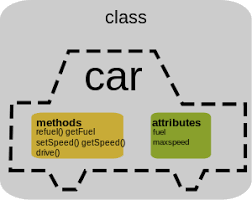

### Describing an object: attributes
Think about how you would describe a car. It has properties such as the make, model, year, mileage, size, etc. Each of these properties make the car object what it is. In Python such properties are called *attributes*.

You can access attributes with the dot operator: `object.attribute_name`

This will return the value that is stored in the attribute variable of that object.

### Actions of an object: methods
What are the actions a car can do, or can be done to the car? Let’s take some of the obvious ones:
- Turn the car on
- Turn the car off
- Accelerate
- Brake

In OOP, these actions, are called methods. They allow the objects to do things, and as you’ll see next, also provide a way to manipulate the properties of the object. Methods are the characteristic functions of an object.

Accessing the methods of an object is similar to accessing the attributes: `object.method_name()`.

You can list all the attributes and methods of an object with `dir(object)`.

In [ ]:
# modules are imported as objects
import requests
import bs4

# We call get() that belongs to the requests-object.
# This creates a new object of type Response as defined by the requests library.
r = requests.get('https://www.lt3.ugent.be/publications')
print(type(r))

# We can print all attributes and methods of an object with dir()
print(dir(r))

# We access the .text attribute of the Response object r.
# The value of the .text attribute is the webpage HTML response as a string.
html = r.text 

# We parse the raw HTML by making a BeautifulSoup object.
# In order to make the object, we have to pass the html string and the parser to the object.
soup = bs4.BeautifulSoup(html, "lxml")
print(type(soup))
print(dir(soup))

# We call the findall() method of the BeautifulSoup object in order to find the html elements.
for link in soup.find_all("a"):
    print(link["href"])

## Final exercises

Ex.1:

Print all the table elements from the following page: https://en.wikipedia.org/wiki/List_of_state_and_union_territory_capitals_in_India

<tr>
<th style="padding:0.2em 0.4em 0.2em;font-size:145%;line-height:1.2em"><a href="/wiki/States_and_union_territories_of_India" title="States and union territories of India">States and union<br/>
territories of India</a><br/>
ordered by</th>
</tr>
<tr>
<td style="padding:0.2em 0 0.4em">
<div class="center">
<div class="floatnone"><a class="image" href="/wiki/File:Flag_of_India.svg"><img alt="Flag of India.svg" data-file-height="900" data-file-width="1350" height="47" src="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/70px-Flag_of_India.svg.png" srcset="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/105px-Flag_of_India.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/140px-Flag_of_India.svg.png 2x" width="70"/></a></div>
</div>
</td>
</tr>
<tr>
<td class="hlist" style="padding:0 0.1em 0.4em">
<ul>
<li><a class="mw-redirect" href="/wiki/List_of_states_and_territories_of_India_by_area" title="List of states and territori

Ex.2:

Print all the urls **linking to other wikipedia articles only** from the Python page. `https://en.wikipedia.org/wiki/Python_(programming_language)`

In [8]:
# your code here

/wiki/Wikipedia:Good_articles
/wiki/File:Python_logo_and_wordmark.svg
/wiki/Programming_paradigm
/wiki/Object-oriented_programming
/wiki/Imperative_programming
/wiki/Functional_programming
/wiki/Procedural_programming
/wiki/Reflective_programming
/wiki/Software_design
/wiki/Guido_van_Rossum
/wiki/Software_developer
/wiki/Python_Software_Foundation
/wiki/Software_release_life_cycle
/wiki/Type_system
/wiki/Duck_typing
/wiki/Dynamic_typing
/wiki/Strong_typing
/wiki/Software_license
/wiki/Python_Software_Foundation_License
/wiki/Filename_extension
/wiki/Programming_language_implementation
/wiki/CPython
/wiki/IronPython
/wiki/Jython
/wiki/MicroPython
/wiki/Numba
/wiki/PyPy
/wiki/Stackless_Python
/wiki/Dialect_(computing)
/wiki/Cython
/wiki/RPython
/wiki/ABC_(programming_language)
/wiki/ALGOL_68
/wiki/C_(programming_language)
/wiki/C%2B%2B
/wiki/CLU_(programming_language)
/wiki/Dylan_(programming_language)
/wiki/Haskell_(programming_language)
/wiki/Icon_(programming_language)
/wiki/Java_(pro

------------------------------

You've reached the end of Chapter 7! You can safely ignore the code below, it's only there to make the page pretty:

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()